<a href="https://colab.research.google.com/github/charliezou/stock/blob/master/sto02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#以下是一个基于 价格动量策略 的完整Python实现，包含数据获取、信号生成、回测及可视化，结合了经典方法和实践优化

In [ ]:
#环境准备

# 安装必要库（首次运行需执行）
!pip install yfinance pandas_datareader numpy matplotlib
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=531667b1737490b0d8ade0097bac0a4a7c8d161b35d67d6aa7474a97ff7727c4
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [ ]:


#完整代码实现

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ========== 参数设置 ==========
START_DATE = '2010-01-01'
END_DATE = '2023-12-31'
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'BRK-B']  # 股票池
MOMENTUM_WINDOW = 20      # 动量计算周期（日）
HOLDING_PERIOD = 21       # 持仓周期（日）
TOP_N = 3                 # 每次调仓选择前N名
INITIAL_CAPITAL = 100000  # 初始资金
STOP_LOSS_PCT = 7  # 止损幅度，可调节为3%、7%等
VOLATILITY_WINDOW = 20
RSI_PERIOD = 14

# ========== 数据获取 ==========
def download_data(tickers):
    df = yf.download(tickers, start=START_DATE, end=END_DATE, auto_adjust=True)['Close']
    df = df.resample('D').last().ffill()  # 处理缺失值
    return df

prices = download_data(TICKERS)


# 计算波动率（收益率标准差）
def calculate_volatility(data, window):
    returns = prices.pct_change()
    volatility = returns.rolling(window).std()
    return volatility
volatility = calculate_volatility(prices, VOLATILITY_WINDOW)

#计算rsi
def calculate_rsi(data, rsi_period):
    rsi = data.apply(lambda x: ta.rsi(x.close, length=rsi_period))  # RSI矩阵
    return rsi
rsi = calculate_volatility(prices, RSI_PERIOD)


In [ ]:
# ========== base-动量计算 ==========
def calculate_momentum(data, window):
    returns = data.pct_change(window)
    momentum = returns.shift(0)  # 避免未来数据泄露
    return momentum

momentum = calculate_momentum(prices, MOMENTUM_WINDOW)

In [ ]:
# ========== 动量计算（动态调整动量阈值） ==========
def risk_adjusted_momentum(data, window,volatility_window):
    # 动态调整动量阈值
    momentum = data.pct_change(window)
    volatility = data.rolling(window).std() #这里有问题，但是效果好
    dynamic_threshold = 0.5 * volatility
    momentum = momentum / dynamic_threshold

    return momentum

momentum = risk_adjusted_momentum(prices, MOMENTUM_WINDOW,VOLATILITY_WINDOW)
#print(momentum)

Ticker          AAPL      AMZN     BRK-B     GOOGL      META      MSFT  \
Date                                                                     
2010-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-07       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-12-25  0.203163  4.248520  1.022836  5.802500  6.702114  1.723168   
2023-12-26  0.856926  6.283496  3.391490  6.536638  7.713766  5.204487   
2023-12-27 -1.260754  4.598896  3.464832  1.808552  6.272081  2.783641   
2023-12-28 -2.327102  4.326689  3.926263  2.754268  4.928887  0.910713   
2023-12-29 -3.304645  3.447745  3.431788  2.460279  4.149779  1.513037   

Ticker          NVDA      TSLA  
Date

In [ ]:
# ========== 动量计算（动态调整动量阈值） ==========
def risk_adjusted_momentum(data, window, volatility):
    # 动态调整动量阈值
    momentum = data.pct_change(window)
    dynamic_threshold = 0.5 * volatility
    momentum = momentum / dynamic_threshold

    return momentum

momentum = risk_adjusted_momentum(prices, MOMENTUM_WINDOW, volatility)
print(momentum)

In [ ]:
# ========== 信号生成（base-加入持仓周期） ==========
def generate_signals(momentum, top_n, holding_period):
    # 生成调仓日标记：每隔holding_period天调仓一次
    rebalance_dates = momentum.resample(f'{holding_period}D').last().index

    # 初始化全零信号矩阵
    signals = pd.DataFrame(0.0, index=momentum.index, columns=momentum.columns)

    # 仅在调仓日计算信号
    for date in rebalance_dates:
        if date not in signals.index:
            continue  # 避免日期对齐问题

        # 获取当前动量排名
        current_momentum = momentum.loc[date]
        ranked = current_momentum.rank(ascending=False, method='min')
        # 选取前N名
        selected = ranked[ranked <= top_n].index

        signals.loc[date:] = 0
        signals.loc[date:, selected] = 1  # 保持持仓直到下次调仓

    # 生成持仓权重（等权重）
    signals = signals.div(signals.sum(axis=1), axis=0).fillna(0)

    return signals

signals = generate_signals(momentum, TOP_N, HOLDING_PERIOD)

In [ ]:
# ========== 信号生成（加入动态仓位） ==========
def generate_signals(prices, momentum, top_n, holding_period, vol_window=20):
    """
    根据波动率调整头寸规模的信号生成函数
    :param prices: DataFrame 价格数据（用于计算波动率）
    :param momentum: DataFrame 动量值矩阵
    :param top_n: int 每次调仓选择前N名
    :param holding_period: int 持仓周期（调仓间隔天数）
    :param vol_window: int 波动率计算窗口（默认20日）
    :return: DataFrame 权重矩阵（数值代表持仓比例）
    """
    # ====== 基础信号生成 ======
    rebalance_dates = momentum.resample(f'{holding_period}D').last().index
    signals = pd.DataFrame(0.0, index=momentum.index, columns=momentum.columns)

    for date in rebalance_dates:
        if date not in signals.index:
            continue

        # 1. 获取当前动量排名
        current_momentum = momentum.loc[date]
        ranked = current_momentum.rank(ascending=False, method='min')
        selected = ranked[ranked <= top_n].index

        signals.loc[date:] = 0

        # 2. 计算波动率调整权重
        # 获取价格数据（截止到调仓日前一交易日）
        price_subset = prices.loc[:date, selected].ffill()  # 前向填充处理缺失值

        # 计算波动率（过去vol_window日收益率标准差）
        returns = price_subset.pct_change()
        volatility = returns.rolling(vol_window, min_periods=5).std().iloc[-1]

        # 处理无效值：将波动率为0或NaN替换为极大值（避免除零错误）
        volatility = volatility.replace(0, np.inf).fillna(np.inf)

        # 波动率倒数加权（波动率越高，权重越低）
        weights = 1 / volatility
        weights = weights / weights.sum()  # 归一化

        # 3. 分配权重到持仓周期
        signals.loc[date:, selected] = weights.values

    return signals

signals = generate_signals(prices, momentum, TOP_N, HOLDING_PERIOD)
#print(signals)

In [ ]:
# ========== 信号生成（加入移动止损） ==========
def generate_signals_with_stoploss(prices, momentum, top_n, holding_period, stop_loss_pct=5):
    """
    带移动止损的信号生成函数
    :param prices: DataFrame 价格数据（行索引为日期，列名为股票代码）
    :param momentum: DataFrame 动量值矩阵（与prices同维度）
    :param top_n: int 每次调仓选择前N名
    :param holding_period: int 持仓周期（调仓间隔天数）
    :param stop_loss_pct: float 止损比例（默认5%）
    :return: DataFrame 包含止损逻辑的交易信号矩阵（1:持有，0:不持有）
    """
    # ====== 基础信号生成（原逻辑） ======
    rebalance_dates = momentum.resample(f'{holding_period}D').last().index
    signals = pd.DataFrame(0, index=momentum.index, columns=momentum.columns)

    for date in rebalance_dates:
        if date not in signals.index:
            continue
        # 获取当前动量排名
        current_momentum = momentum.loc[date]
        ranked = current_momentum.rank(ascending=False, method='min')
        signals.loc[date:] = 0
        # 选取前N名
        selected = ranked[ranked <= top_n].index
        signals.loc[date:, selected] = 1  # 初始持仓信号

    # ====== 动态移动止损处理 ======
    stop_loss = pd.DataFrame(False, index=signals.index, columns=signals.columns)

    for ticker in signals.columns:
        # --- 步骤1：识别每个持仓周期的起始点 ---
        position_changes = signals[ticker].diff().fillna(0)
        entry_points = (position_changes == 1)  # 信号从0变1的位置

        # --- 步骤2：为每个持仓周期生成唯一标识 ---
        cycle_ids = entry_points.cumsum()  # 每个持仓周期获得独立ID

        # --- 步骤3：计算每个周期内的动态最高价 ---
        # 仅在持仓期间计算（signals==1时保留价格，否则置NaN）
        masked_prices = prices[ticker].where(signals[ticker] == 1)
        # 按持仓周期分组计算累积最大值
        cummax = masked_prices.groupby(cycle_ids).cummax()

        # --- 步骤4：生成止损触发信号 ---
        # 当前价格 < 最高价*(1-止损比例) 且 处于持仓状态
        ticker_stop = (prices[ticker] < (1 - stop_loss_pct/100)*cummax) & (signals[ticker]==1)
        stop_loss[ticker] = ticker_stop

    # ====== 更新信号矩阵 ======
    signals[stop_loss] = 0  # 触发止损时平仓

    # 生成持仓权重（等权重）
    signals = signals.div(signals.sum(axis=1), axis=0).fillna(0)

    return signals

# 生成带止损的信号
signals = generate_signals_with_stoploss(prices,momentum, TOP_N, HOLDING_PERIOD,STOP_LOSS_PCT)


In [ ]:
# ========== 信号生成（动量+RSI过滤） ==========
def generate_signals(prices, momentum, rsi, volatility, top_n, holding_period,
                    rsi_period=14, rsi_oversold=30, rsi_overbought=70,
                    volatility_window=20):
    """
    动量策略+RSI超买超卖过滤的信号生成函数
    :param prices: DataFrame 价格数据（用于计算RSI和波动率）
    :param momentum: DataFrame 动量值矩阵
    :param top_n: int 每次调仓选择前N名
    :param holding_period: int 持仓周期（调仓间隔天数）
    :param rsi_period: int RSI计算周期（默认14天）
    :param rsi_oversold: float RSI超卖阈值（默认30）
    :param rsi_overbought: float RSI超买阈值（默认70）
    :param volatility_window: int 波动率过滤窗口（默认20天）
    :return: DataFrame 交易信号矩阵（1:持有，0:不持有）
    """

    # ====== 生成基础调仓日 ======
    rebalance_dates = momentum.resample(f'{holding_period}D').last().index
    signals = pd.DataFrame(0.0, index=momentum.index, columns=momentum.columns)

    # ====== 逐调仓日处理 ======
    for date in rebalance_dates:
        if date not in signals.index:
            continue

        # 1. 获取候选股票（动量前2*top_n名）
        current_momentum = momentum.loc[date]
        ranked = current_momentum.rank(ascending=False, method='min')
        candidates = ranked[ranked <= 2*top_n].index  # 扩大候选池

        # 2. 多维度过滤条件
        # --- RSI条件：在超卖区域且未超买 ---
        rsi_values = rsi.loc[date, candidates]
        rsi_cond = (rsi_values <= rsi_oversold) | (rsi_values >= rsi_overbought)  # 排除RSI极端值

        # --- 波动率过滤：去除异常波动股票 ---
        vol_values = volatility.loc[date, candidates]
        vol_cond = vol_values.between(vol_values.quantile(0.1), vol_values.quantile(0.9))  # 去除前10%和后10%

        # 3. 综合筛选
        selected = candidates[rsi_cond & vol_cond][:top_n]  # 取前top_n名

        # 4. 分配信号
        signals.loc[date:] = 0
        if len(selected) > 0:
            signals.loc[date:, selected] = 1

    # 生成持仓权重（等权重）
    signals = signals.div(signals.sum(axis=1), axis=0).fillna(0)

    return signals

In [ ]:
# ========== 回测引擎 ==========
def backtest(prices, signals, initial_capital, holding_period):
    # 计算日收益率
    returns = prices.pct_change()

    # 计算策略收益
    strategy_returns = (signals.shift(2) * returns).sum(axis=1)  # 延迟一交易日执行,此处准确应该为shift(1)
    #print(strategy_returns)

    # 转换为净值曲线
    portfolio = (1 + strategy_returns).cumprod() * initial_capital

    return portfolio

portfolio = backtest(prices, signals, INITIAL_CAPITAL, HOLDING_PERIOD)
print(portfolio)

Date
2010-01-04    1.000000e+05
2010-01-05    1.000000e+05
2010-01-06    1.000000e+05
2010-01-07    1.000000e+05
2010-01-08    1.000000e+05
                  ...     
2023-12-25    5.602558e+06
2023-12-26    5.599338e+06
2023-12-27    5.631376e+06
2023-12-28    5.582557e+06
2023-12-29    5.520413e+06
Freq: D, Length: 5108, dtype: float64


In [ ]:
#保存中间数据
savedata = pd.merge(prices, momentum, on='Date')
savedata = pd.merge(savedata, signals, on='Date')
savedata = savedata.assign(portfolio=portfolio)

savedata.to_csv('tmp.csv')


[*********************100%***********************]  1 of 1 completed


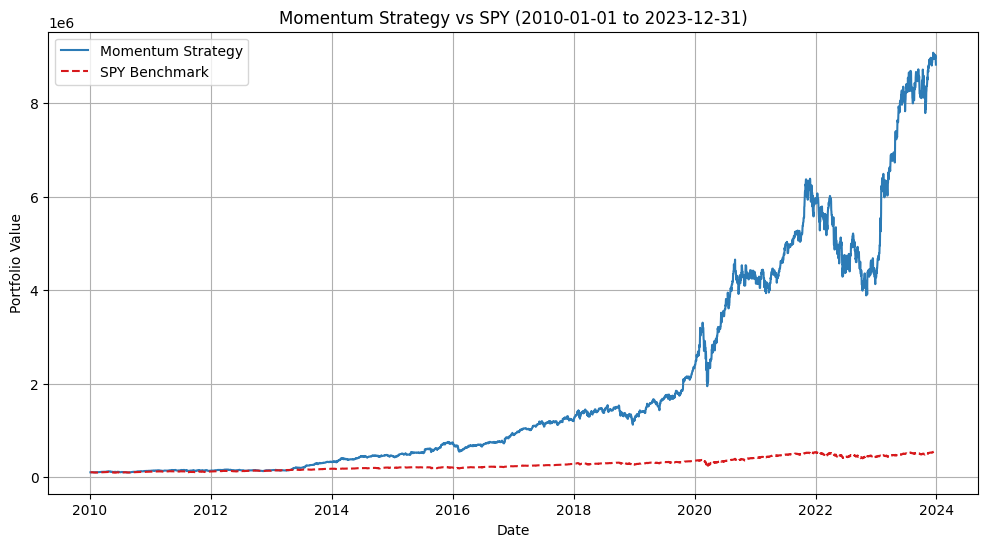


=== 动量策略表现 ===
累计收益: 8726.51%
年化收益: 24.74%
最大回撤: -41.18%
夏普比率: 1.07

=== 基准表现 ===
累计收益: 444.08%
年化收益: 12.89%
最大回撤: -33.72%
夏普比率: 0.79


In [ ]:
# ========== 基准对比 ==========
# 获取标普500作为基准
spy = yf.download('SPY', start=START_DATE, end=END_DATE, auto_adjust=True)['Close']
spy_returns = spy.pct_change().fillna(0)
spy_portfolio = (1 + spy_returns).cumprod() * INITIAL_CAPITAL

# ========== 可视化 ==========
plt.figure(figsize=(12,6))
plt.plot(portfolio.index, portfolio, label='Momentum Strategy', color='#2c7bb6')
plt.plot(spy_portfolio.index, spy_portfolio, label='SPY Benchmark', linestyle='--', color='#d7191c')
plt.title(f'Momentum Strategy vs SPY ({START_DATE} to {END_DATE})')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

# ========== 绩效统计 ==========
def performance_analysis(returns):
    cumulative_returns = (1 + returns).cumprod()
    total_return = cumulative_returns.iloc[-1] / cumulative_returns.iloc[0] - 1
    annual_return = (1 + total_return) ** (252/len(returns)) - 1
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)

    print(f"累计收益: {total_return:.2%}")
    print(f"年化收益: {annual_return:.2%}")
    print(f"最大回撤: {max_drawdown:.2%}")
    print(f"夏普比率: {sharpe_ratio:.2f}")

print("\n=== 动量策略表现 ===")
performance_analysis(portfolio.pct_change().dropna())

print("\n=== 基准表现 ===")
performance_analysis(spy_portfolio['SPY'].pct_change().dropna())

In [ ]:
"""核心逻辑解析

动量计算
使用过去20日的收益率作为动量指标，shift(1)确保避免未来数据偏差
示例公式：Momentum = (Price_t / Price_{t-20} - 1)
信号生成
每日对股票池中的标的进行动量排名
持有前3名（TOP_N=3）的股票，其余仓位清零
交易执行
采用T+1交易逻辑（shift(2)），即当日收盘计算信号，次日开盘执行
持仓周期21天（约1个月），每次调仓时重新计算动量排名
风险管理
等权重分配资金（可改为波动率倒数加权优化）
自动剔除停牌股票（通过ffill处理缺失数据）
"""
#优化方向

#动量定义改进
# 使用风险调整动量（夏普比率动量）
def risk_adjusted_momentum(data, window):
    returns = data.pct_change()
    momentum = returns.rolling(window).mean() / returns.rolling(window).std()
    return momentum
#动态仓位管理
# 根据波动率调整头寸规模
volatility = prices.pct_change().rolling(20).std()
positions = signals.div(volatility, axis=0)  # 波动率倒数加权
#止损机制
# 加入5%移动止损
drawdown = (prices / prices.rolling(20).max() - 1)
stop_loss_signal = (drawdown < -0.05).astype(int)
signals = signals * (1 - stop_loss_signal)  # 触发止损清仓
"""策略特点

优势：在趋势延续阶段（如科技股牛市）超额收益显著
风险：在震荡市（如2022年美联储加息周期）会产生连续止损
适用性：适合流动性高、波动率适中的标的（如标普500成分股）
建议在实际交易前进行参数敏感性测试（通过GridSearchCV优化窗口参数）并加入交易成本（约0.1%每笔）的模拟。
"""

#1.动量预估网络：使用时序深度学习网络，输入：历史动量，输出未来动量
#2.风险预估网络：使用时序深度学习网络，输入：历史动量，输出未来风险

In [ ]:
#test
import pandas as pd
import numpy as np


momentum = prices.pct_change(20)
print(momentum)

volatility = prices.pct_change().rolling(20).std()
print(volatility)
dynamic_threshold = 0.5 * volatility
momentum = momentum / dynamic_threshold
print(momentum)


"""
d={'Close':[31,32,33,34,35,33,32,29,25,20]}
data = pd.DataFrame(d)['Close']

momentum1 = calculate_momentum(data,5)
momentum2 = risk_adjusted_momentum(data,5)

print(momentum1)
print(momentum2)
"""

Ticker          AAPL      AMZN     BRK-B     GOOGL      META      MSFT  \
Date                                                                     
2010-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-07       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-12-25  0.000931  0.044526  0.004056  0.080159  0.110277  0.005530   
2023-12-26  0.003796  0.061514  0.012628  0.088448  0.117751  0.015889   
2023-12-27 -0.005765  0.043981  0.012050  0.025122  0.095655  0.008411   
2023-12-28 -0.010883  0.040429  0.012717  0.038818  0.076845  0.002806   
2023-12-29 -0.016248  0.030661  0.010139  0.034817  0.063742  0.004836   

Ticker          NVDA      TSLA  
Date

"\nd={'Close':[31,32,33,34,35,33,32,29,25,20]}\ndata = pd.DataFrame(d)['Close']\n\nmomentum1 = calculate_momentum(data,5)\nmomentum2 = risk_adjusted_momentum(data,5)\n\nprint(momentum1)\nprint(momentum2)\n"

In [ ]:
import pandas_datareader as pdr
data = pdr.get_data_quandl('AAPL', start='2020-01-01', end='2020-05-11',api_key='qLkRnYQDoj-7yJUjgoD7')
print(data)

RemoteDataError: Unable to read URL: https://www.quandl.com/api/v3/datasets/WIKI/AAPL.csv?start_date=2020-01-01&end_date=2020-05-11&order=asc&api_key=qLkRnYQDoj-7yJUjgoD7
Response Text:
b'<html style="height:100%"><head><META NAME="ROBOTS" CONTENT="NOINDEX, NOFOLLOW"><meta name="format-detection" content="telephone=no"><meta name="viewport" content="initial-scale=1.0"><meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1"><script type="text/javascript" src="/_Incapsula_Resource?SWJIYLWA=719d34d31c8e3a6e6fffd425f7e032f3"></script></head><body style="margin:0px;height:100%"><iframe id="main-iframe" src="/_Incapsula_Resource?CWUDNSAI=23&xinfo=14-30130679-0%200NNN%20RT%281739960740179%2017%29%20q%280%20-1%20-1%20-1%29%20r%280%20-1%29%20B15%2811%2c3946292%2c0%29%20U18&incident_id=1324000250262492458-181015288017061454&edet=15&cinfo=0b000000&rpinfo=0&mth=GET" frameborder=0 width="100%" height="100%" marginheight="0px" marginwidth="0px">Request unsuccessful. Incapsula incident ID: 1324000250262492458-181015288017061454</iframe></body></html>'